In [2]:
!pip show fastai fastcore

Name: fastai
Version: 2.0.15
Summary: fastai simplifies training fast and accurate neural nets using modern best practices
Home-page: https://github.com/fastai/fastai/tree/master/
Author: Jeremy Howard, Sylvain Gugger, and contributors
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: torchvision, scikit-learn, packaging, pip, pyyaml, pillow, torch, fastprogress, requests, spacy, scipy, pandas, fastcore, matplotlib
Required-by: 
---
Name: fastcore
Version: 1.0.16
Summary: Python supercharged for fastai development
Home-page: https://github.com/fastai/fastcore/tree/master/
Author: Jeremy Howard and Sylvain Gugger
Author-email: infos@fast.ai
License: Apache Software License 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: packaging, pip
Required-by: fastai


In [2]:
from matplotlib import cm
from fastai.tabular.all import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)

We'll use the `Adult Sample` dataset:

In [3]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

And declare the relevent information:

In [4]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'
y_block = CategoryBlock()
splits = RandomSplitter()(range_of(df))

Next we need our own version of `ReadTabBatch` that will return our inputs

> The continous variables are still normalized if we used `Normalize`. Couldn't figure out an easy way to de-norm it, but it's okay that we do not

In [5]:
class ReadTabBatchIdentity(ItemTransform):
    "Read a batch of data and return the inputs as both `x` and `y`"
    def __init__(self, to): store_attr()

    def encodes(self, to):
        if not to.with_cont: res = (tensor(to.cats).long(),) + (tensor(to.cats).long(),)
        else: res = (tensor(to.cats).long(),tensor(to.conts).float()) + (tensor(to.cats).long(), tensor(to.conts).float())
        if to.device is not None: res = to_device(res, to.device)
        return res
    
class TabularPandasIdentity(TabularPandas): pass

Next we need to make a new `TabDataLoader` that uses our `RadTabBatchIdentity`:

In [6]:
@delegates()
class TabDataLoaderIdentity(TabDataLoader):
    "A transformed `DataLoader` for AutoEncoder problems with Tabular data"
    do_item = noops
    def __init__(self, dataset, bs=16, shuffle=False, after_batch=None, num_workers=0, **kwargs):
        if after_batch is None: after_batch = L(TransformBlock().batch_tfms)+ReadTabBatchIdentity(dataset)
        super().__init__(dataset, bs=bs, shuffle=shuffle, after_batch=after_batch, num_workers=num_workers, **kwargs)

    def create_batch(self, b): return self.dataset.iloc[b]

And make `TabularPandasIdentity`'s `dl_type` to `TabDataLoaderIdentity`

In [7]:
TabularPandasIdentity._dl_type = TabDataLoaderIdentity

To start we'll make a very basic `to` object using our new `TabularPandasIdentity`:

In [8]:
bs=1024

to = TabularPandasIdentity(df, [Categorify, FillMissing, Normalize], cat_names, cont_names, splits=RandomSplitter(seed=32)(df))
dls = to.dataloaders(bs=1024)

Set the `n_inp` to 2:

In [9]:
dls.n_inp = 2

And then we'll calculate the embedding sizes:

In [10]:
emb_szs = get_emb_sz(to.train)

For each categorical variable we need to know the total possible values it can have:

In [11]:
total_cats = {k:len(v) for k,v in to.classes.items()}
total_cats

{'workclass': 10,
 'education': 17,
 'marital-status': 8,
 'occupation': 16,
 'relationship': 7,
 'race': 6,
 'education-num_na': 3}

We will need this dictionary in our loss function to figure out where to apply our `CrossEntropyLossFlat` for each categorical variables

Next we need to know the total number ouf outputs possible for our categorical variables

In [12]:
sum([v for k,v in total_cats.items()])

67

And let's keep a batch of our data for later

In [13]:
batch = dls.one_batch()

Next we need to know the means and standard deviations:

In [14]:
to.means

{'age': 38.5793696495067,
 'fnlwgt': 190006.02011593536,
 'education-num': 10.079158782958984}

We can store them in a `DataFrame` for easy adjustments:

In [15]:
means = pd.DataFrame.from_dict({k:[v] for k,v in to.means.items()})
stds = pd.DataFrame.from_dict({k:[v] for k,v in to.stds.items()})

We'll also use a SigmoidRange based on the un-normalized data to reduce the range our values can be:

In [16]:
low = (df[cont_names].min().to_frame().T.values - means.values) / stds.values
high = (df[cont_names].max().to_frame().T.values - means.values) / stds.values

In [17]:
low, high

(array([[-1.57952443, -1.67843578, -3.55622464]]),
 array([[ 3.76378659, 12.22741736,  2.31914013]]))

## Batch Swap Noise
Used in the winning solution for the Kaggle competition [Puerto Seguro Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/44629#250927)

In [18]:
class BatchSwapNoise(Module):
    "Swap Noise Module"
    def __init__(self, p): store_attr()

    def forward(self, x):
        if self.training:
            mask = torch.rand(x.size()) > (1 - self.p)
            l1 = torch.floor(torch.rand(x.size()) * x.size(0)).type(torch.LongTensor)
            l2 = (mask.type(torch.LongTensor) * x.size(1))
            res = (l1 * l2).view(-1)
            idx = torch.arange(x.nelement()) + res
            idx[idx>=x.nelement()] = idx[idx>=x.nelement()]-x.nelement()
            return x.flatten()[idx].view(x.size())
        else:
            return x

We'll make a custom `TabularVAE` model (Denoising Variational AutoEncoder) for us to use.

In [77]:
class TabularVAE(TabularModel):
    def __init__(self, emb_szs, n_cont, hidden_size, cats, low, high, ps=0.2, embed_p=0.01, bswap=None, act_cls=Swish()):
        super().__init__(emb_szs, n_cont, layers=[1024, 512, 256], out_sz=hidden_size, embed_p=embed_p, act_cls=act_cls)
        
        self.bswap = bswap
        self.cats = cats
        self.activation_cats = sum([v for k,v in cats.items()])
        
        self.layers = nn.Sequential(*L(self.layers.children())[:-1] + nn.Sequential(LinBnDrop(256, hidden_size, p=ps, act=act_cls)))
        
        self.fc_mu = nn.Linear(hidden_size, hidden_size)
        self.fc_std = nn.Linear(hidden_size, hidden_size)
        
        if self.bswap != None: self.noise = BatchSwapNoise(self.bswap)
        self.decoder = nn.Sequential(
            LinBnDrop(hidden_size, 256, p=ps, act=act_cls),
            LinBnDrop(256, 512, p=ps, act=act_cls),
            LinBnDrop(512, 1024, p=ps, act=act_cls)
        )
        
        self.decoder_cont = nn.Sequential(
            LinBnDrop(1024, n_cont, p=ps, bn=False, act=None),
            SigmoidRange(low=low, high=high)
        )
        
        self.decoder_cat = LinBnDrop(1024, self.activation_cats, p=ps, bn=False, act=None)
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.cuda.HalfTensor(*mu.size()).normal_()
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc_mu(h), F.softplus(self.fc_std(h))
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def forward(self, x_cat, x_cont=None, encode=False):
        if(self.bswap != None):
            x_cat = self.noise(x_cat)
            x_cont = self.noise(x_cont)
        
        encoded = super().forward(x_cat, x_cont)
        z, mu, logvar = self.bottleneck(encoded)
        if(encode): return z
        
        decoded_trunk = self.decoder(z)
        
        decoded_cats = self.decoder_cat(decoded_trunk)
        
        decoded_conts = self.decoder_cont(decoded_trunk)
        
        return decoded_cats, decoded_conts, mu, logvar

We'll also need a loss function that can grade how well our features represent the original dataset. 

The categorical features will be graded on `CrossEntropyLossFlat` and the continous with `MSELossFlat`.

Since this is a Variationnal AutoEncoder, we have to worry about KL-Divergence too.  kl_weight is a special parameter controlled by a callback.  At the beginning this parameter will be zero (basically like a normal autoencoder) and we will gradually increase it to 1 so that the auto-encoder become variationnal.  This is a trick suggested in [Ladder Variational AutoEncoder](https://arxiv.org/abs/1602.02282) and also used in the [NVAE](https://arxiv.org/abs/2007.03898) paper.

In [78]:
class VAERecreatedLoss(Module):
    "Measures how well we have created the original tabular inputs, plus the KL Divergence with the unit normal distribution"
    def __init__(self, cat_dict, dataset_size, bs):
        ce = CrossEntropyLossFlat(reduction='sum')
        mse = MSELossFlat(reduction='sum')
        store_attr('cat_dict,ce,mse,dataset_size,bs')
        
    def forward(self, preds, cat_targs, cont_targs):
        if(len(preds) == 5):
            cats,conts, mu, logvar, kl_weight = preds
        else:
            cats,conts, mu, logvar = preds
            kl_weight = 1

        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        CE = cats.new([0])
        pos=0
        for i, (k,v) in enumerate(total_cats.items()):
            CE += self.ce(cats[:, pos:pos+v], cat_targs[:, i])
            pos += v

        norm_cats = cats.new([len(total_cats.keys())])
        norm_conts = conts.new([conts.size(1)])
        total = (self.mse(conts, cont_targs)/norm_conts) + (CE/norm_cats)
        
        # This factor depends on your batch size and the size of the dataset.  A good rule of thumb is df.shape[0] / batch_size
        # if we don't have this, the KLD loss might become much larger than the reconstruction loss
        total *= self.dataset_size / self.bs

        return (total + (kl_weight * KLD)) / cats.size(0)

All we need to do is pass in our `total_cats` dictionary:

In [79]:
loss_func = VAERecreatedLoss(total_cats, df.shape[0], bs)

Let's create some metrics for stuff we care about while fitting the model.  We have reconstruction metrics like MSE and CrossEntropy but we also have to worry about KLD.
Those metrics will help us see if the loss is dominated either by the KLD or by the reconstruction loss from MSE and CrossEntropy 

In [80]:
class MSEMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        cats, conts, mu, logvar = learn.pred
        cat_targs, cont_targs = learn.y
        norm_conts = conts.new([conts.size(1)])
        self.preds.append(to_detach(F.mse_loss(conts, cont_targs, reduction='sum') / norm_conts))
    @property
    def value(self):
        return np.array(self.preds).mean()
    
class CEMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        cats, conts, mu, logvar = learn.pred
        cat_targs, cont_targs = learn.y
        CE = cats.new([0])
        pos=0
        for i, (k,v) in enumerate(total_cats.items()):
            CE += F.cross_entropy(cats[:, pos:pos+v], cat_targs[:, i], reduction='sum')
            pos += v

        norm = cats.new([len(total_cats.keys())])
        self.preds.append(to_detach(CE/norm))
    @property
    def value(self):
        return np.array(self.preds).mean()
    
class KLDMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        cats, conts, mu, logvar = learn.pred
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        self.preds.append(to_detach(KLD))
    @property
    def value(self):
        return np.array(self.preds).mean()
    
class MUMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        cats, conts, mu, logvar = learn.pred
        self.preds.append(to_detach(mu.mean()))
    @property
    def value(self):
        return np.array(self.preds).mean()
    
class StdMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        cats, conts, mu, logvar = learn.pred
        self.preds.append(to_detach((logvar.exp_() ** .5).mean()))
    @property
    def value(self):
        return np.array(self.preds).mean()

AnnealedLossCallback will inject the variable `kl_weight` in our loss.  You can see the schedule graph of the parameter.  At the beginning it will be 0, thus the KLD part of the loss will get ignored.  So during 10% of training, we will fit a normal auto-encoder.  Then gradually for 30% of trainning, increase `kl_weight` to 1 and then remain there for the remaining training time so that the auto encoder now becomes full variational.  The way this callback is done, the loss will receive this parameter, but not the model.

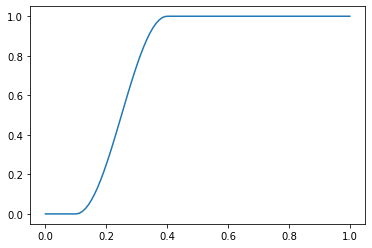

In [81]:
class AnnealedLossCallback(Callback):
    def after_pred(self):
        kl = self.learn.pred[0].new(1)
        kl[0] = self.opt.hypers[0]['kl_weight']
        self.learn.pred = self.learn.pred + (kl,)
    def after_batch(self):
        if(len(self.learn.pred)):
            cats, conts, mu, logvar, _ = self.learn.pred
        else:
            cats, conts, mu, logvar = self.learn.pred
            
        self.learn.pred = (cats, conts, mu, logvar)
        
f = combine_scheds([.1, .3, .6], [SchedCos(0,0), SchedCos(0,1), SchedNo(1,1)])
p = torch.linspace(0.,1,100)
plt.plot(p,[f(o) for o in p])

We'll make an config dictionary for us to use as a list of all hyper parameters.  Also I would recommend against using early stopping because our AnnealedLossCallback will make the loss go worst once the KL divergence weight become larger than 0.

In [82]:
config = {
    'hidden_size': 128,
    'dropout': 0.0,
    'embed_p': 0.0,
    'wd': 0.01,
    'bswap': 0.1,
    'lr': 1e-3,
    'epochs': 100
}

cbs = [ParamScheduler({'kl_weight': f }), AnnealedLossCallback()]
metrics = [MSEMetric(), CEMetric(), KLDMetric(), MUMetric(), StdMetric()]

And make our model & `Learner`

In [83]:
model = TabularVAE(emb_szs, len(cont_names), config['hidden_size'], ps=config['dropout'], cats=total_cats, embed_p=config['embed_p'], bswap=config['bswap'], low=tensor(low).cuda(), high=tensor(high).cuda())
learn = Learner(dls, model, lr=config['lr'], loss_func=loss_func, wd=config['wd'], opt_func=ranger, cbs=cbs, metrics=metrics).to_fp16()

Finally we'll fit for a few epochs:

In [84]:
learn.fit_flat_cos(config['epochs'], lr=4e-3)

epoch,train_loss,valid_loss,mse,ce,kld,mu,std,time
0,315.605652,129.085739,1875.5427,1901.0209,18535.082,0.0017046062,1.4117877,00:03
1,176.394974,75.675156,1545.153,1450.1143,62741.055,-0.012652379,1.3945049,00:03
2,123.456360,64.680702,1439.2533,1188.363,123300.29,-0.021421198,1.3422272,00:04
3,97.023422,57.760181,1387.2825,1005.8914,213299.9,-0.028006313,1.2807553,00:04
4,81.636597,51.438267,1348.5676,866.9492,281948.94,-0.032968253,1.234925,00:04
5,71.761780,47.578621,1322.5017,755.7578,342068.38,-0.036913283,1.2001842,00:04
6,65.135506,46.210411,1305.7738,668.72626,411158.25,-0.040174223,1.1736237,00:04
7,60.570484,44.721779,1291.7133,599.52313,486491.78,-0.04356434,1.1530076,00:04
8,57.616035,43.848965,1280.4219,543.21704,553554.44,-0.045224637,1.1367451,00:04
9,55.411850,43.521729,1271.6382,496.96478,633306.1,-0.047541678,1.1235219,00:04


# Getting the compressed representations

Next we're going to grade our compressed representations and then attempt to train on them.

In [85]:
dl = learn.dls.test_dl(df)

Let's predict over all the data manually using PyTorch:

In [86]:
outs = []
for batch in dl:
    with torch.no_grad():
        learn.model.eval()
        learn.model.cuda()
        out = learn.model(*batch[:2], True).cpu().numpy()
        outs.append(out)
outs = np.concatenate(outs)

In [87]:
outs.shape

(32561, 128)

As well as get the actual preds and targs:

In [88]:
(cat_preds, cont_preds, mu, logvar), (cat_targs, cont_targs) = learn.get_preds(dl=dl)

# Measuring accuracy

## Continuous

In [89]:
from sklearn.metrics import r2_score

cont_preds = pd.DataFrame(cont_preds, columns=cont_names)
cont_targs = pd.DataFrame(cont_targs, columns=cont_names)

preds = pd.DataFrame((cont_preds.values * stds.values) + means.values, columns=cont_preds.columns)
targets = pd.DataFrame((cont_targs.values * stds.values) + means.values, columns=cont_targs.columns)

mi = (np.abs(targets-preds)).min().to_frame().T
ma = (np.abs(targets-preds)).max().to_frame().T
mean = (np.abs(targets-preds)).mean().to_frame().T
median = (np.abs(targets-preds)).median().to_frame().T
r2 = pd.DataFrame.from_dict({c:[r2_score(targets[c], preds[c])] for c in preds.columns})


for d,name in zip([mi,ma,mean,median,r2], ['Min', 'Max', 'Mean', 'Median', 'R2']):
    d = d.insert(0, 'GroupBy', name)
    
data = pd.concat([mi,ma,mean,median,r2])
data

,GroupBy,age,fnlwgt,education-num
0,Min,0.000,1.076,0.000
0,Max,62.191,360954.983,10.133
0,Mean,4.637,41901.621,0.374
0,Median,3.698,34951.056,0.181
0,R2,0.800,0.745,0.933


We can also grab the R2:

In [90]:
r2.mean(axis=1)

0   0.826
dtype: float64

## Categorical

In [91]:
cat_reduced = torch.zeros_like(cat_targs)
pos=0
for i, (k,v) in enumerate(total_cats.items()):
    cat_reduced[:,i] = cat_preds[:,pos:pos+v].argmax(dim=1)
    pos += v

In [92]:
cat_preds = pd.DataFrame(cat_reduced, columns=cat_names)
cat_targs = pd.DataFrame(cat_targs, columns=cat_names)

from sklearn.metrics import balanced_accuracy_score, f1_score

accuracy = pd.DataFrame.from_dict({c:[balanced_accuracy_score(cat_targs[c], cat_preds[c])] for c in cat_preds.columns})

In [93]:
f1 = pd.DataFrame.from_dict({c:[f1_score(cat_targs[c], cat_preds[c], average='weighted')] for c in cat_preds.columns})

In [94]:
for d,name in zip([accuracy, f1], ['Accuracy', 'F1']):
    d = d.insert(0, 'MetricName', name)
pd.concat([accuracy, f1])

,MetricName,workclass,education,marital-status,occupation,relationship,race,education-num_na
0,Accuracy,0.650,0.818,0.714,0.755,0.842,0.648,0.867
0,F1,0.898,0.904,0.923,0.810,0.901,0.931,0.994


And check it's overall accuracy:

In [95]:
accuracy.mean(axis=1)

0   0.756
dtype: float64

## Predicting

Now that we have our compressed representations, let's use them to train a new model

In [96]:
ys = df['salary'].to_numpy()

In [97]:
test_eq(len(outs), len(ys))

In [98]:
df_outs = pd.DataFrame(columns=['salary'] + list(range(0,128)))

In [99]:
df_outs['salary'] = ys

In [100]:
df_outs[list(range(0,128))] = outs

In [101]:
pd.options.mode.chained_assignment=None

In [102]:
splits = RandomSplitter()(range_of(df))

In [103]:
df_outs[list(range(0,128))] = df_outs[list(range(0,128))].astype(np.float16)

In [104]:
cont_names = list(range(0,128))
to = TabularPandas(df_outs, procs = [Normalize], cont_names=cont_names, splits=splits, y_names=['salary'], reduce_memory=False, 
                   y_block=CategoryBlock())

In [105]:
dls = to.dataloaders(bs=1024)

In [106]:
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

In [107]:
learn = tabular_learner(dls, layers=[200,100], metrics=[accuracy])

In [108]:
learn.fit(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.442242,0.435455,0.791769,00:00
1,0.410507,0.431449,0.791308,00:00
2,0.385457,0.444674,0.785166,00:00
3,0.358744,0.485525,0.765663,00:00
4,0.325381,0.568057,0.761824,00:00
